# Figures for Adding EHR Data with Raw Count of ICD-9 & CPT  

In [23]:
import os, sys
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import glob 
import pickle 
from scipy.cluster.hierarchy import linkage,leaves_list
from scipy.interpolate import interp1d
from cycler import cycler
from collections import OrderedDict 

from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
from IPython.core.display import display, HTML    
display(HTML("<style>.container {width:90% !important; }</style>"))
%matplotlib inline
np.set_printoptions(precision=5, suppress=True) 

DATE = datetime.now().strftime('%Y-%m-%d')

In [2]:
sys.path.append('/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification')
from hyperparam_tune import validate_best_model

In [3]:
import shap

In [4]:
%load_ext rpy2.ipython

In [5]:
ROOT_DATA_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/results/ptb_predict_machine_learning/2019-01-21_manuscript_add_ehr_data" 
BIN_CLIN_DATA_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/results/ptb_predict_machine_learning/2019_09_05_add_clin_labs/bin_labs"
CLIN_DATA_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/results/ptb_predict_machine_learning/2019_09_05_add_clin_labs/lab_values"
OUTPUT_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/add_ehr_data"

## Functions

In [6]:
def get_test_performance(input_file, model_file):
    
    
    input_data = pd.read_csv(input_file, sep="\t")
    print("done loading {}".format(os.path.basename(input_file)))
    
    held_out_df = input_data.loc[input_data['partition']=='held_out'].copy()
    train_df = input_data.loc[input_data['partition']=='grid_cv'].copy()
    held_out_df.set_index('GRID',inplace=True)
    train_df.set_index('GRID',inplace=True)
    
    X_test = held_out_df.iloc[:,:-2]
    y_test = held_out_df.label.apply(lambda x: 1 if x == 'preterm' else 0).values

    
    xgb_model = pickle.load(open(model_file, "rb"))
    
    return X_test, y_test, xgb_model 

In [7]:
def plot_roc(store_fpr, store_tpr, aucs, plt_prefix='', roc_fig_file=None):
    '''
    plot auroc curve(s) with mean and std; save if a roc_fig_file is provided

        INPUTS:
            * store_fpr, store_tpr, aucs: a list where each element represents data for one curve
            * plt_prefix: label to add to the title of plot
            * roc_fig_file: full path to save file
            * savefig: boolean to save or not save figure

        note: first three must be a list; will not plot mean and std if only one curve
    '''
    print("Creating roc plot.....")

    interp_fpr = np.linspace(0, 1, 100)
    store_tpr_interp = []

    ax = plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r', label='Chance', alpha=.8)

    # plot each cv iteration
    for cv_iter, fpr_tpr_auc in enumerate(zip(store_fpr, store_tpr, aucs)):
        # set_trace()
        fpr, tpr, auc = fpr_tpr_auc
        plt.plot(fpr, tpr, lw=4, alpha=0.9, label="#{}(AUC={:.3f})".format(cv_iter, auc))

        lin_fx = interp1d(fpr, tpr, kind='linear')
        interp_tpr = lin_fx(interp_fpr)

        # store_tpr_interp.append(np.interp(mean_fpr, fpr, tpr))
        # store_tpr_interp[-1][0] = 0.0
        store_tpr_interp.append(interp_tpr)

    # plot mean and std only if more than one curve present
    if len(store_fpr) != 1:
        # plot mean, sd, and shade in between
        mean_tpr = np.mean(store_tpr_interp, axis=0)
        # mean_tpr[-1] = 1.0
        mean_auc = metrics.auc(interp_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(interp_fpr, mean_tpr, color='b',
                 label="Mean(AUC={:.2f}+/-{:.2f})".format(mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(store_tpr_interp, axis=0)
        tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
        plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label="+/- 2 S.D.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}:\nPrediting PTB vs. non-PTB'.format(plt_prefix))
    plt.legend(loc="lower right")

    if roc_fig_file:
        plt.savefig(roc_fig_file)
        print("\tDone. AUROC curve saved to:\n\t{}".format(roc_fig_file))

    return ax

In [8]:
def plot_pr(precisions, recalls, avg_prs, plt_prefix, pr_fig_file=None, pos_prop=None):
    ''' plot PR curve(s) with mean and std; save if pr_fig_file is provided

        INPUTS:
            * precisions, recalls, avg_prs: must be a list where each element represents data for one curve
            * plt_prefix: label to add to the title of plot
            * pr_fig_file: full path to save file
            * pos_prop: total true positives / total samples (i.e. proportion of positves)

        note: first three must be a list; will not plot mean and std if only one curve
    '''
    print("Creating PR curve plot ...")
    # mean_rc = np.linspace(0, 1, 100)
    interp_rc = np.linspace(0, 1, 100)

    store_pr_interp = []
    ax = plt.figure()

    # plot line of random chance
    if pos_prop:
        plt.plot([0, 1], [pos_prop, pos_prop], linestyle='--', lw=4,
                 color='r', label='Chance({:.3f})'.format(pos_prop), alpha=.8)

    # plot each cv_iter
    for cv_iter, pr_rc_avg in enumerate(zip(precisions, recalls, avg_prs)):

        pr_array, rc_array, pr_avg = pr_rc_avg
        # plt.plot(rc_array, pr_array, lw=1, color='k', alpha=0.4)
        plt.step(rc_array, pr_array, lw=4, alpha=0.8, where='post', label="#{}(AvgPR={:.3f})".format(cv_iter, pr_avg))

        # interpolate recall to have the same length array for taking mean
        lin_fx = interp1d(rc_array, pr_array, kind='linear')
        interp_pr = lin_fx(interp_rc)
        store_pr_interp.append(interp_pr)

    # set_trace()

    # plot mean and std only if more than one curve present
    if len(precisions) != 1:
        # mean and std
        mean_pr = np.mean(store_pr_interp, axis=0)
        mean_avg_pr = np.mean(avg_prs)
        std_avg_pr = np.std(avg_prs)

        # std of each pr-curve
        std_pr = np.std(store_pr_interp, axis=0)
        pr_upper = np.minimum(mean_pr + 2*std_pr, 1)
        pr_lower = np.maximum(mean_pr - 2*std_pr, 0)
        plt.fill_between(interp_rc, pr_lower, pr_upper, color='grey', alpha=.2,
                         label="+/- 2 S.D.")

        plt.plot(interp_rc, mean_pr, color='b',
                 label="Mean(AUC={:.2f}+/-{:.2f})".format(mean_avg_pr, std_avg_pr), lw=2, alpha=0.8)

    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve for {}:\nPrediting PTB vs. non-PTB'.format(plt_prefix))
    plt.legend(loc="lower right")

    if pr_fig_file:
        plt.savefig(pr_fig_file)
        print("\tPR curve saved to:\n\t{}".format(pr_fig_file))

    return ax

In [112]:
def autolabel(rects, ax, fprop=None):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontproperties=fprop)

## Load Data 

In [9]:
dataset_dict = OrderedDict()
for dlabel in ['age_race','obnotes','prs','unstruc' ,'bin_labs','clin_labs']: 
    
    for flabel in ['all','icd_cpt', 'only']:

        if dlabel == 'bin_labs':
               
            input_file = glob.glob(BIN_CLIN_DATA_DIR+'/*/input_data_vs_{}_{}*'.format(dlabel, flabel) )[0]
            model_file = glob.glob(BIN_CLIN_DATA_DIR+'/*/best_xgb_model_vs_{}_{}*'.format(dlabel,flabel))[0]

        elif dlabel == 'clin_labs': 
            input_file = glob.glob(CLIN_DATA_DIR+'/*/input_data_vs_{}_{}*'.format(dlabel, flabel) )[0]
            model_file = glob.glob(CLIN_DATA_DIR+'/*/best_xgb_model_vs_{}_{}*'.format(dlabel,flabel))[0]

        else: 

            input_file = glob.glob(ROOT_DATA_DIR+'/*/input_data_vs_{}__{}*'.format(dlabel,flabel))[0]
            model_file = glob.glob(ROOT_DATA_DIR+'/*/best_xgb_model_vs_{}__{}*'.format(dlabel,flabel))[0]

        dataset_dict['{}_{}'.format(dlabel,flabel)] =  {'input_file': input_file, 'model_file': model_file}


In [12]:
STORED_DATA_FILE = os.path.join(OUTPUT_DIR,'add_ehr_datasets_dict_with_labs.pickle')

In [13]:
# load if the data already exists... 

if os.path.isfile(STORED_DATA_FILE):     
    print("loading pickled file...")
    metrics_file = open(STORED_DATA_FILE, 'rb')
    dataset_dict = pickle.load(metrics_file)
else: 
    print("creating data...")
    store_results = {}
    for label, inner_dict in dataset_dict.items(): 

        print(label)
        X_test, y_test, xgb_model  = get_test_performance(inner_dict['input_file'], inner_dict['model_file'])
        metrics_results, metrics_df, model_params = validate_best_model(xgb_model, X_test, y_test)

        dataset_dict[label]['metrics_df'] = metrics_df
        dataset_dict[label]['metrics_results'] = metrics_results
        dataset_dict[label]['y_test'] = y_test
        dataset_dict[label]['X_test'] = X_test

loading pickled file...


In [14]:
#  save stored dictionary
if not os.path.isfile(STORED_DATA_FILE): 
    pickle.dump(dataset_dict, open(STORED_DATA_FILE, 'wb'))    
    print("pickled model.")

## Create metrics dataframe

In [15]:
# concat metrics_df 
all_metrics_df = pd.DataFrame()
for label, inner_dict in dataset_dict.items(): 
    
    print(label)
    metrics_df = inner_dict['metrics_df']
#     metrics_df['dataset'] = mod_labels[label]
    metrics_df['dataset'] = label
    all_metrics_df = all_metrics_df.append(metrics_df)

age_race_all
age_race_icd_cpt
age_race_only
obnotes_all
obnotes_icd_cpt
obnotes_only
prs_all
prs_icd_cpt
prs_only
unstruc_all
unstruc_icd_cpt
unstruc_only
bin_labs_all
bin_labs_icd_cpt
bin_labs_only
clin_labs_all
clin_labs_icd_cpt
clin_labs_only


In [16]:
all_metrics_df.loc[all_metrics_df['dataset'].apply(lambda x: True if (x.find('all') > -1) else False), 'model'] = 'all'
all_metrics_df.loc[all_metrics_df['dataset'].apply(lambda x: True if (x.find('only') > -1) else False), 'model'] = 'only'
all_metrics_df.loc[all_metrics_df['dataset'].apply(lambda x: True if (x.find('icd_cpt') > -1) else False), 'model'] = 'baseline'


all_metrics_df['data'] = all_metrics_df['dataset'].apply(lambda x: x.replace('_all','').replace('_icd_cpt','').replace('_only',''))

In [17]:
all_metrics_df['random_pr'] = (all_metrics_df.tp_count + all_metrics_df.fn_count)/all_metrics_df.total_count

In [18]:
# new lables 
mod_labels = {'age_race_all':'ICD+CPT+age_race', 'age_race_icd_cpt':'ICD+CPT', 'age_race_only':'age_race',
              'obnotes_all':'ICD+CPT+obnotes', 'obnotes_icd_cpt':'ICD+CPT', 'obnotes_only':'obnotes',
              'prs_all':'ICD+CPT+prs', 'prs_icd_cpt':'ICD+CPT', 'prs_only':'prs',
              'unstruc_all':'ICD+CPT+unstruc', 'unstruc_icd_cpt':'ICD+CPT', 'unstruc_only':'unstruc',
              'bin_labs_all':'ICD+CPT+binary_labs', 'bin_labs_icd_cpt':'ICD+CPT', 'bin_labs_only':'binary_labs',
              'clin_labs_all':'ICD+CPT+labs', 'clin_labs_icd_cpt':'ICD+CPT', 'clin_labs_only':'labs'
             }

## AUC Barplots

In [148]:
all_metrics_df.head()
rand_pr_dict = dict(zip(all_metrics_df.dataset, all_metrics_df.random_pr))

,precision,recall,f1,roc_auc,avg_pr,tn_count,fp_count,fn_count,tp_count,brier_score,total_count,dataset,model,data,random_pr
0,0.753876,0.804273,0.778259,0.947556,0.863059,4882,381,284,1167,0.073213,6714,age_race_all,all,age_race,0.216116
0,0.756270,0.810476,0.782435,0.949259,0.867206,4884,379,275,1176,0.072467,6714,age_race_icd_cpt,baseline,age_race,0.216116
0,0.254864,0.451413,0.325790,0.567973,0.255310,3348,1915,796,655,0.247490,6714,age_race_only,only,age_race,0.216116
0,0.542254,0.836957,0.658120,0.923297,0.791065,385,65,15,77,0.111939,542,obnotes_all,all,obnotes,0.169742
0,0.635514,0.739130,0.683417,0.915411,0.781074,411,39,24,68,0.078857,542,obnotes_icd_cpt,baseline,obnotes,0.169742


In [149]:
# melt dataframe
raw_melted_metrics_df = pd.melt(all_metrics_df, id_vars=['model', 'data','dataset'], value_vars=['roc_auc','avg_pr'] )
raw_melted_metrics_df.variable = raw_melted_metrics_df.variable.str.upper()


In [150]:
raw_melted_metrics_df.loc[raw_melted_metrics_df['variable'] == 'ROC_AUC', 'variable'] = 'ROC AUC'
raw_melted_metrics_df.loc[raw_melted_metrics_df['variable'] == 'AVG_PR', 'variable'] = 'PR AUC'

In [151]:
melted_metrics_df = raw_melted_metrics_df.loc[raw_melted_metrics_df['data']!='bin_labs'].copy()

In [152]:
# udpate random expected value 
random_df = melted_metrics_df.copy()
random_df.loc[random_df['variable']=='ROC_AUC', 'value'] = 0.50 
random_df.loc[random_df['variable']=='AVG_PR', 'value'] = random_df.loc[random_df['variable']=='AVG_PR', 'dataset'].map(rand_pr_dict)

In [153]:
# set up fonts
fpath='/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Arial.ttf'
prop = fm.FontProperties(fname=fpath, size=16)

In [154]:
# change model names 
model_names = {'all':'Both', 'baseline':'ICD&CPT', 'only':'EHR feature'}
melted_metrics_df['model'] = melted_metrics_df.model.map(model_names)

# change EHR feature names 
feat_names = {'age_race':'Age&Race', 'obnotes':'Clinical history', 'prs':'Genetic risk', 'unstruc':'Clinical keywords', 'clin_labs':'Clinical labs'}


In [184]:
ehr_feature_labels

['age_race', 'obnotes', 'prs', 'unstruc', 'clin_labs']

In [202]:
# specify plt positions
bottom = 0.05
height = 0.9
width = 0.15  # * 4 = 0.6 - minus the 0.1 padding 0.3 left for space
left1, left2, left3, left4, left5 = 0.05, 0.25, 1 - 0.25 - width, 1 - 0.05 - width, 1 - 0.05 - width


rectangle1 = [left1, bottom, width, height]
rectangle2 = [left2, bottom, width, height]
rectangle3 = [left3, bottom, width, height]
rectangle4 = [left4, bottom, width, height]
rectangle5 = [left5, bottom, width, height]

/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


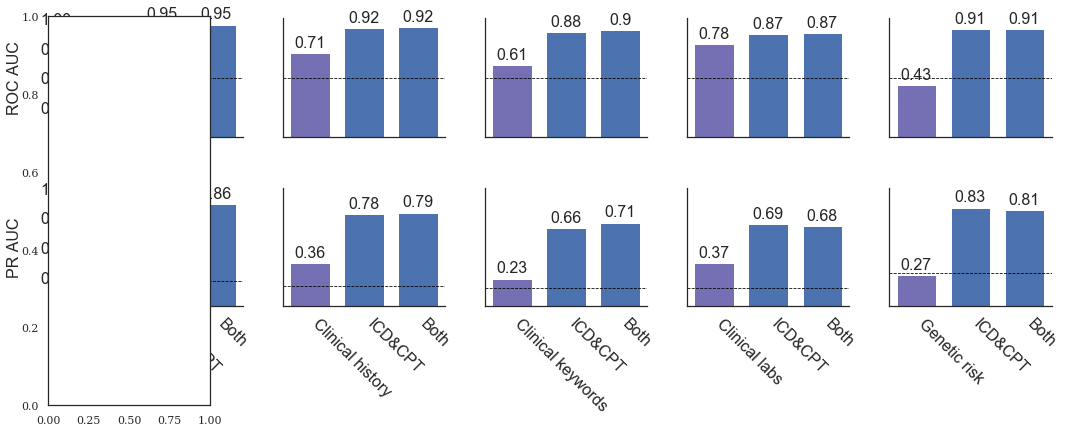

In [204]:
# set_style()
metric_type = melted_metrics_df.variable.unique().tolist()
ehr_feature_labels = ['age_race', 'obnotes',  'unstruc', 'clin_labs', 'prs',]

# order and position of bars
x_model_labels =  ['EHR feature','ICD&CPT','Both']
x_coords = [0, 0.75, 1.5]

# the width of the bars
width = 0.55  

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(3*5,6), sharex=False, sharey=True)



for row in range(len(metric_type)): 
    for col in range(len(ehr_feature_labels)):

        col_name = ehr_feature_labels[col]

        
        models = melted_metrics_df.loc[  (melted_metrics_df['variable'] == metric_type[row]) & (melted_metrics_df['data'] == ehr_feature_labels[col])].copy()
        
        # get y_values
        y_vals = []
        for this_model in x_model_labels: 
            y_vals.append(models.loc[models['model']==this_model, 'value'].values.tolist()[0])

        this_ax = axs[row, col]
#         plt.axes(rectangle1)
        
        # format 
        this_ax.grid(False)
        this_ax.spines['right'].set_visible(False)
        this_ax.spines['top'].set_visible(False)
        
        # draw bars
        rects1 = this_ax.bar(x_coords, y_vals, width)
        rects2 = this_ax.bar(x_coords[0], y_vals[0], width, color='#7570b3')
        _ = this_ax.set_ylim(0,1)

        # add y-labels 
        autolabel(rects1, this_ax, prop)

        if row == 1:
            _ = this_ax.set_xticks(x_coords)
            _ = this_ax.set_xticklabels([feat_names[col_name] if x == 'EHR feature' else x for x in x_model_labels], fontproperties=prop, rotation = 315, ha="left")
            _ = this_ax.axhline(y=rand_pr_dict[col_name+"_all"], color='black', ls='--', lw=0.8)
        else: 
            _ = this_ax.axhline(y=0.5, color='black', ls='--', lw=0.8)
            _ = this_ax.set_xticklabels([''])
            _ = this_ax.tick_params(axis='x', which='major', length=0)
            
        
        if col == 0: 
            _ = this_ax.set_ylabel(metric_type[row], labelpad=18, fontproperties=prop)
            _ = this_ax.set_yticks(np.arange(0,1.25,0.25))
            _ = this_ax.set_yticklabels(['%.2f' % x if x != 0 else '0' for x in np.arange(0,1.25,0.25).tolist()], fontproperties=prop)
            _ = this_ax.tick_params(axis='y', direction='out', left=True)
            
fig.tight_layout(h_pad=3, w_pad=2)

plt.savefig(os.path.join(OUTPUT_DIR, '{}_add_ehr_barplot.pdf'.format(DATE)))

Make nicer plot for manuscript

In [186]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

['Clinical labs', 'ICD&CPT', 'Both']